# Support Vector Machine (SVM) Classification on PCA dataset

Link to Excel file of extracted features: https://drive.google.com/drive/u/1/folders/1ZMbW7HxNkBUAlnT-_lXLD4J_r0A778SJ

In [1]:
# import required packages
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score


In [2]:
# read in features csv file
df = pd.read_csv('k_pca_features.csv')
df

PC1       PC2       PC3       PC4  label
0   1.919234  1.225710 -1.287233  0.285046  k_pre
1   1.629080 -0.495292 -0.689883  0.365053  k_pre
2   2.341778 -1.181016 -0.758231  0.174319  k_pre
3   1.229193  0.930177 -0.746822  0.327738  k_pre
4   1.881406 -0.417269 -0.858387  0.351611  k_pre
..       ...       ...       ...       ...    ...
91 -0.584261  3.824609 -0.579344 -0.546390  k_med
92 -0.489981  2.892255  0.260431 -0.950496  k_med
93 -2.153267  2.608921  0.641948 -0.166193  k_med
94 -0.443943  3.236324 -0.394600 -0.524103  k_med
95  0.402208  3.711258 -0.561773 -0.895813  k_med

[96 rows x 5 columns]

In [3]:
# encode meditative/non-meditative labels
categories = {'k_pre':0,'k_med':1}
df['label'] = df['label'].replace(categories)
df

PC1       PC2       PC3       PC4  label
0   1.919234  1.225710 -1.287233  0.285046      0
1   1.629080 -0.495292 -0.689883  0.365053      0
2   2.341778 -1.181016 -0.758231  0.174319      0
3   1.229193  0.930177 -0.746822  0.327738      0
4   1.881406 -0.417269 -0.858387  0.351611      0
..       ...       ...       ...       ...    ...
91 -0.584261  3.824609 -0.579344 -0.546390      1
92 -0.489981  2.892255  0.260431 -0.950496      1
93 -2.153267  2.608921  0.641948 -0.166193      1
94 -0.443943  3.236324 -0.394600 -0.524103      1
95  0.402208  3.711258 -0.561773 -0.895813      1

[96 rows x 5 columns]

In [4]:
# split dependent and independent variables
# target variable
Y = df['label'].values
# features
X = df.drop(labels = ['label'], axis = 1)
features_list = list(X.columns)

# Standardizing the features
X = StandardScaler().fit_transform(X)

In [5]:
# split training and testing dataset: 70% training, 30% testing
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size = 0.3,random_state = 42)

## Linear SVM

In [6]:
# create lists of possible parameters for linear SVM
# to be used in grid search to find the best possible parameters later

lin_clf_loss = ['hinge', 'squared_hinge']
lin_clf_dual = [True,False]
lin_clf_tol = [0.001,0.0001,0.00001]

# Create the grid
lin_grid = {'loss': lin_clf_loss,
               'dual': lin_clf_dual,
               'tol': lin_clf_tol}

lin_grid

{'loss': ['hinge', 'squared_hinge'],
 'dual': [True, False],
 'tol': [0.001, 0.0001, 1e-05]}

In [7]:
# run parameters through model and find best set of parameters
# this step splits the training data into mini train/test datasets to find the best hyperparameters for the model

import time
print(time.ctime(time.time()))

# Create the model to be tuned
lin_base = svm.LinearSVC()

# Create the random search to find best hyperparameters
lin_random = RandomizedSearchCV(estimator = lin_base, 
                                param_distributions = lin_grid, 
                                n_iter = 20,
                                cv = 10, 
                                verbose = 2, 
                                random_state = 42, 
                                n_jobs = -1)

# Fit the random search model on training data
lin_random.fit(X_train, y_train)

print(time.ctime(time.time()))

Sat Apr 24 18:13:30 2021
Fitting 10 folds for each of 12 candidates, totalling 120 fits


/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:278: UserWarning: The total space of parameters 12 is smaller than n_iter=20. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Sat Apr 24 18:13:32 2021


[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    2.8s finished


In [8]:
cv_results = pd.DataFrame.from_dict(lin_random.cv_results_)
labels = ['param_loss','param_dual','param_tol','mean_test_score','rank_test_score']
cv_sub = cv_results[labels]
cv_sub = cv_sub.sort_values(by='rank_test_score')
cv_sub

param_loss param_dual param_tol  mean_test_score  rank_test_score
0           hinge       True     0.001         0.971429                1
1           hinge       True    0.0001         0.971429                1
2           hinge       True   0.00001         0.971429                1
3   squared_hinge       True     0.001         0.971429                1
4   squared_hinge       True    0.0001         0.971429                1
5   squared_hinge       True   0.00001         0.971429                1
9   squared_hinge      False     0.001         0.971429                1
10  squared_hinge      False    0.0001         0.971429                1
11  squared_hinge      False   0.00001         0.971429                1
6           hinge      False     0.001              NaN               10
7           hinge      False    0.0001              NaN               11
8           hinge      False   0.00001              NaN               12

In [8]:
# show best set of parameters
lin_random.best_params_

{'tol': 0.001, 'loss': 'hinge', 'dual': True}

In [9]:
# Create the linear SVM model
lin_model = svm.LinearSVC(tol = 0.001,
                      loss = 'hinge',
                      dual = True,
                      random_state = 42)

In [10]:
# fit model
lin_model.fit(X_train,y_train)

LinearSVC(loss='hinge', random_state=42, tol=0.001)

In [11]:
# predict y values from testing data
y_pred = lin_model.predict(X_test)

In [12]:
# display results in confusion matrix
cm = confusion_matrix(y_test,y_pred)
cm

results = pd.crosstab(y_test, y_pred, colnames=['Predicted'])
results = results.rename(columns={0: 'Non-Meditative', 1: 'Meditative'})
results.index = ['Non-Meditative', 'Meditative']
index = results.index
index.name = "Actual"
results

Predicted       Non-Meditative  Meditative
Actual                                    
Non-Meditative              17           0
Meditative                   0          12

In [13]:
target_names = ['Non-Meditative', 'Meditative']
print(classification_report(y_test, y_pred, target_names=target_names))

                precision    recall  f1-score   support

Non-Meditative       1.00      1.00      1.00        17
    Meditative       1.00      1.00      1.00        12

      accuracy                           1.00        29
     macro avg       1.00      1.00      1.00        29
  weighted avg       1.00      1.00      1.00        29



In [14]:
# store metrics for comparision amongst SVM kernels later
svm_rec = []
svm_acc = []
svm_pre = []
svm_mcc = []

# obtain metrics for model
recall = metrics.recall_score(y_test,y_pred)
accuracy = metrics.accuracy_score(y_test,y_pred)
precision = metrics.precision_score(y_test,y_pred)
mcc = metrics.matthews_corrcoef(y_test,y_pred)

svm_rec.append(recall)
svm_acc.append(accuracy)
svm_pre.append(precision)
svm_mcc.append(mcc)

# display metrics
print('Linear SVM\n')
print('Sensitivity = %.3f' % recall)
print('Accuracy = %.3f' % accuracy)
print('Precision = %.3f' % precision)
print('Matthew Correlation Coefficient = %.3f' % mcc)


Linear SVM

Sensitivity = 1.000
Accuracy = 1.000
Precision = 1.000
Matthew Correlation Coefficient = 1.000


In [21]:
# cv_rec = []
# cv_acc = []
# cv_pre = []
# cv_mcc = []

# recall = np.mean(cross_val_score(lin_model, X, Y, scoring='recall', cv=10, n_jobs=-1))
# accuracy = np.mean(cross_val_score(lin_model, X, Y, scoring='accuracy', cv=10, n_jobs=-1))
# precision = np.mean(cross_val_score(lin_model, X, Y, scoring='precision', cv=10, n_jobs=-1))
# # mcc = cross_val_score(lin_model, X, Y, scoring='matthews_corrcoef', cv=10, n_jobs=-1)

# cv_rec.append(recall)
# cv_acc.append(accuracy)
# cv_pre.append(precision)
# # cv_mcc.append(mcc)

# # display metrics
# print('Linear SVM (CV results)\n')
# print('Sensitivity = %.3f' % recall)
# print('Accuracy = %.3f' % accuracy)
# print('Precision = %.3f' % precision)
# # print('Matthew Correlation Coefficient = %.3f' % mcc)

Linear SVM (CV results)

Sensitivity = 1.000
Accuracy = 0.980
Precision = 0.971


In [15]:
# show most important features when determining classification category
feature_imp = pd.Series(lin_model.coef_[0], index = features_list).sort_values(ascending = False)
feature_imp

PC2    0.008021
PC3   -0.274251
PC4   -0.602673
PC1   -2.090866
dtype: float64

In [17]:
lin_cv_res = pd.DataFrame.from_dict(lin_random.cv_results_)
lin_cv_res

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_tol  \
0        0.001695      0.000668         0.001215        0.000558     0.001   
1        0.001249      0.000159         0.000679        0.000046    0.0001   
2        0.001385      0.000291         0.000981        0.000765   0.00001   
3        0.001292      0.000199         0.000798        0.000385     0.001   
4        0.001320      0.000152         0.000862        0.000598    0.0001   
5        0.002043      0.001079         0.000980        0.000655   0.00001   
6        0.000973      0.000239         0.000000        0.000000     0.001   
7        0.000918      0.000053         0.000000        0.000000    0.0001   
8        0.000977      0.000126         0.000000        0.000000   0.00001   
9        0.001837      0.001943         0.000650        0.000084     0.001   
10       0.001774      0.001315         0.000656        0.000087    0.0001   
11       0.001176      0.000162         0.000643        0.000099   0.00001   

       param_loss param_dual  \
0           hinge       True   
1           hinge       True   
2           hinge       True   
3   squared_hinge       True   
4   squared_hinge       True   
5   squared_hinge       True   
6           hinge      False   
7           hinge      False   
8           hinge      False   
9   squared_hinge      False   
10  squared_hinge      False   
11  squared_hinge      False   

                                               params  split0_test_score  \
0       {'tol': 0.001, 'loss': 'hinge', 'dual': True}                1.0   
1      {'tol': 0.0001, 'loss': 'hinge', 'dual': True}                1.0   
2       {'tol': 1e-05, 'loss': 'hinge', 'dual': True}                1.0   
3   {'tol': 0.001, 'loss': 'squared_hinge', 'dual'...                1.0   
4   {'tol': 0.0001, 'loss': 'squared_hinge', 'dual...                1.0   
5   {'tol': 1e-05, 'loss': 'squared_hinge', 'dual'...                1.0   
6      {'tol': 0.001, 'loss': 'hinge', 'dual': False}                NaN   
7     {'tol': 0.0001, 'loss': 'hinge', 'dual': False}                NaN   
8      {'tol': 1e-05, 'loss': 'hinge', 'dual': False}                NaN   
9   {'tol': 0.001, 'loss': 'squared_hinge', 'dual'...                1.0   
10  {'tol': 0.0001, 'loss': 'squared_hinge', 'dual...                1.0   
11  {'tol': 1e-05, 'loss': 'squared_hinge', 'dual'...                1.0   

    split1_test_score  ...  split3_test_score  split4_test_score  \
0                 1.0  ...           0.857143           0.857143   
1                 1.0  ...           0.857143           0.857143   
2                 1.0  ...           0.857143           0.857143   
3                 1.0  ...           0.857143           0.857143   
4                 1.0  ...           0.857143           0.857143   
5                 1.0  ...           0.857143           0.857143   
6                 NaN  ...                NaN                NaN   
7                 NaN  ...                NaN                NaN   
8                 NaN  ...                NaN                NaN   
9                 1.0  ...           0.857143           0.857143   
10                1.0  ...           0.857143           0.857143   
11                1.0  ...           0.857143           0.857143   

    split5_test_score  split6_test_score  split7_test_score  \
0                 1.0                1.0                1.0   
1                 1.0                1.0                1.0   
2                 1.0                1.0                1.0   
3                 1.0                1.0                1.0   
4                 1.0                1.0                1.0   
5                 1.0                1.0                1.0   
6                 NaN                NaN                NaN   
7                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
9                 1.0                1.0                1.0   
10   

## Radial Basis Function SVM

In [9]:
# create lists of possible parameters for rbf SVM
# to be used in grid search to find the best possible parameters later

rbf_gamma = [0.1, 1,'scale','auto']
rbf_tol = [0.001,0.0001,0.00001]

# Create the grid
rbf_grid = {'gamma': rbf_gamma,
               'tol': rbf_tol}

rbf_grid


{'gamma': [0.1, 1, 'scale', 'auto'], 'tol': [0.001, 0.0001, 1e-05]}

In [10]:
# run parameters and find set with best score
# this step splits the training data into mini train/test datasets to find the best hyperparameters for the model

print(time.ctime(time.time()))

# Create the model to be tuned
rbf_base = svm.SVC(kernel = 'rbf')

# Create the random search to find best hyperparameters
rbf_random = RandomizedSearchCV(estimator = rbf_base, 
                                param_distributions = rbf_grid, 
                                n_iter = 10,
                                cv = 10, 
                                verbose = 2, 
                                random_state = 42, 
                                n_jobs = -1)

# Fit the random search model on training data
rbf_random.fit(X_train, y_train)

print(time.ctime(time.time()))

Sat Apr 24 18:13:49 2021
Fitting 10 folds for each of 10 candidates, totalling 100 fits
Sat Apr 24 18:13:49 2021


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished


In [11]:
cv_results = pd.DataFrame.from_dict(rbf_random.cv_results_)
labels = ['param_tol','param_gamma','mean_test_score','rank_test_score']
cv_sub = cv_results[labels]
cv_sub = cv_sub.sort_values(by='rank_test_score')
cv_sub

param_tol param_gamma  mean_test_score  rank_test_score
0    0.0001        auto         0.971429                1
1     0.001        auto         0.971429                1
2     0.001         0.1         0.971429                1
3   0.00001       scale         0.971429                1
5   0.00001         0.1         0.971429                1
6    0.0001         0.1         0.971429                1
7   0.00001        auto         0.971429                1
9    0.0001       scale         0.971429                1
4   0.00001           1         0.957143                9
8    0.0001           1         0.957143                9

In [18]:
# display best rbf svm parameters
rbf_random.best_params_

{'tol': 0.0001, 'gamma': 'auto'}

In [19]:
# Create the rbf SVM model
rbf_model = svm.SVC(kernel = 'rbf',
                    tol = 0.0001,
                      gamma = 'auto',
                      random_state = 42)

# fit model
rbf_model.fit(X_train,y_train)

# predict testing data
y_pred = rbf_model.predict(X_test)

# display confusion matrix
results = pd.crosstab(y_test, y_pred, colnames=['Predicted'])
results = results.rename(columns={0: 'Non-Meditative', 1: 'Meditative'})
results.index = ['Non-Meditative', 'Meditative']
index = results.index
index.name = "Actual"
results

Predicted       Non-Meditative  Meditative
Actual                                    
Non-Meditative              16           1
Meditative                   0          12

In [20]:
# obtain metrics of rbf model
recall = metrics.recall_score(y_test,y_pred)
accuracy = metrics.accuracy_score(y_test,y_pred)
precision = metrics.precision_score(y_test,y_pred)
mcc = metrics.matthews_corrcoef(y_test,y_pred)

svm_rec.append(recall)
svm_acc.append(accuracy)
svm_pre.append(precision)
svm_mcc.append(mcc)

print('Radial Basic Function SVM\n')
print('Sensitivity = %.3f' % recall)
print('Accuracy = %.3f' % accuracy)
print('Precision = %.3f' % precision)
print('Matthew Correlation Coefficient = %.3f' % mcc)

Radial Basic Function SVM

Sensitivity = 1.000
Accuracy = 0.966
Precision = 0.923
Matthew Correlation Coefficient = 0.932


In [ ]:
recall = cross_val_score(model, X, y, scoring='recall', cv=cv, n_jobs=-1)
accuracy = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
precision = cross_val_score(model, X, y, scoring='precision', cv=cv, n_jobs=-1)
mcc = cross_val_score(model, X, y, scoring='matthews_corrcoef', cv=cv, n_jobs=-1)

cv_rec.append(recall)
cv_acc.append(accuracy)
cv_pre.append(precision)
cv_mcc.append(mcc)

# display metrics
print('RBF SVM (CV results)\n')
print('Sensitivity = %.3f' % recall)
print('Accuracy = %.3f' % accuracy)
print('Precision = %.3f' % precision)
print('Matthew Correlation Coefficient = %.3f' % mcc)

## Polynomial SVM

In [12]:
# create lists of possible parameters for polynomial SVM
# to be used in grid search to find the best possible parameters later

poly_degree = [2,3,4,5,6,7]
poly_gamma = [0.1, 1,'scale','auto']
poly_tol = [0.001,0.0001,0.00001]

# Create the grid
poly_grid = {'gamma': poly_gamma,
            'degree': poly_degree,
               'tol': poly_tol}

poly_grid


{'gamma': [0.1, 1, 'scale', 'auto'],
 'degree': [2, 3, 4, 5, 6, 7],
 'tol': [0.001, 0.0001, 1e-05]}

In [13]:
# this step splits the training data into mini train/test datasets to find the best hyperparameters for the model

print(time.ctime(time.time()))

# Create the model to be tuned
poly_base = svm.SVC(kernel = 'poly')

# Create the random search to find best hyperparameters
poly_random = RandomizedSearchCV(estimator = poly_base, 
                                param_distributions = poly_grid, 
                                n_iter = 100,
                                cv = 10, 
                                verbose = 2, 
                                random_state = 42, 
                                n_jobs = -1)

# Fit the random search model on training data
poly_random.fit(X_train, y_train)

print(time.ctime(time.time()))

Sat Apr 24 18:14:02 2021
Fitting 10 folds for each of 72 candidates, totalling 720 fits


/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:278: UserWarning: The total space of parameters 72 is smaller than n_iter=100. Running 72 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    0.3s


Sat Apr 24 18:14:03 2021


[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:    0.9s finished


In [14]:
cv_results = pd.DataFrame.from_dict(poly_random.cv_results_)
labels = ['param_tol','param_gamma','param_degree','mean_test_score','rank_test_score']
cv_sub = cv_results[labels]
cv_sub = cv_sub.sort_values(by='rank_test_score')
cv_sub

param_tol param_gamma param_degree  mean_test_score  rank_test_score
17   0.00001           1            3         0.954762                1
16    0.0001           1            3         0.954762                1
15     0.001           1            3         0.954762                1
39     0.001           1            5         0.923810                4
41   0.00001           1            5         0.923810                4
..       ...         ...          ...              ...              ...
48     0.001         0.1            6         0.550000               61
26   0.00001         0.1            4         0.550000               61
36     0.001         0.1            5         0.550000               61
38   0.00001         0.1            5         0.550000               61
37    0.0001         0.1            5         0.550000               61

[72 rows x 5 columns]

In [23]:
# display best polynomial svm parameters
poly_random.best_params_

{'tol': 0.001, 'gamma': 1, 'degree': 3}

In [24]:
# Create the poly SVM model
poly_model = svm.SVC(kernel = 'poly',
                    tol = 0.001,
                    gamma = 1,
                    degree = 3,
                    random_state = 42)

# fit model
poly_model.fit(X_train,y_train)

# predict test data
y_pred = poly_model.predict(X_test)

# confusion matrix
results = pd.crosstab(y_test, y_pred, colnames=['Predicted'])
results = results.rename(columns={0: 'Non-Meditative', 1: 'Meditative'})
results.index = ['Non-Meditative', 'Meditative']
index = results.index
index.name = "Actual"
results

Predicted       Non-Meditative  Meditative
Actual                                    
Non-Meditative              16           1
Meditative                   4           8

In [25]:
# evaluation metrics of poly svm model
recall = metrics.recall_score(y_test,y_pred)
accuracy = metrics.accuracy_score(y_test,y_pred)
precision = metrics.precision_score(y_test,y_pred)
mcc = metrics.matthews_corrcoef(y_test,y_pred)

svm_rec.append(recall)
svm_acc.append(accuracy)
svm_pre.append(precision)
svm_mcc.append(mcc)

print('Polynomial SVM\n')
print('Sensitivity = %.3f' % recall)
print('Accuracy = %.3f' % accuracy)
print('Precision = %.3f' % precision)
print('Matthew Correlation Coefficient = %.3f' % mcc)

Polynomial SVM

Sensitivity = 0.667
Accuracy = 0.828
Precision = 0.889
Matthew Correlation Coefficient = 0.647


In [ ]:
recall = cross_val_score(model, X, y, scoring='recall', cv=cv, n_jobs=-1)
accuracy = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
precision = cross_val_score(model, X, y, scoring='precision', cv=cv, n_jobs=-1)
mcc = cross_val_score(model, X, y, scoring='matthews_corrcoef', cv=cv, n_jobs=-1)

cv_rec.append(recall)
cv_acc.append(accuracy)
cv_pre.append(precision)
cv_mcc.append(mcc)

# display metrics
print('Polynomial SVM (CV results)\n')
print('Sensitivity = %.3f' % recall)
print('Accuracy = %.3f' % accuracy)
print('Precision = %.3f' % precision)
print('Matthew Correlation Coefficient = %.3f' % mcc)

### Comparison Between SVM models

In [26]:
df = pd.DataFrame()

df['svm kernel'] = ['linear','rbf','poly']
df['sensitivity'] = svm_rec
df['accuracy'] = svm_acc
df['precision'] = svm_pre
df['mcc'] = svm_mcc

df

svm kernel  sensitivity  accuracy  precision       mcc
0     linear     1.000000  1.000000   1.000000  1.000000
1        rbf     1.000000  0.965517   0.923077  0.932083
2       poly     0.666667  0.827586   0.888889  0.647098

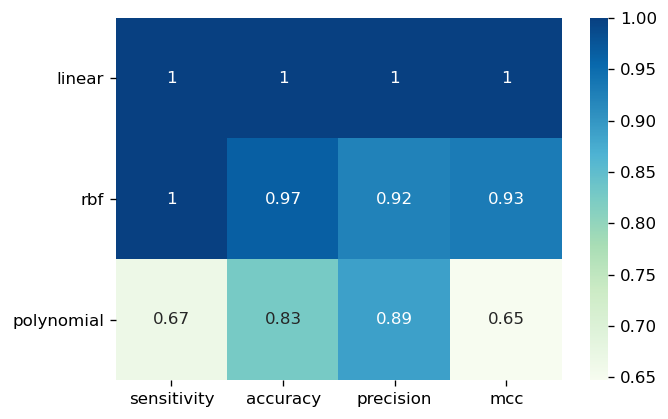

In [27]:
y_axis_labels = ['linear','rbf','polynomial']

plt.figure(dpi = 120)
ax = sns.heatmap(df.iloc[:, 1:],
                 cmap = 'GnBu',
                 annot = True,
                 yticklabels = y_axis_labels,
                )

plt.yticks(rotation=0) 
plt.show()

Linear SVM showed best performance overall